In [18]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import numpy as np

def create_dataset_torch(dataset_name, dataset_dir, batch_size=64, test_size=0.2, random_state=42):
    # 定义数据转换
    if dataset_name == 'CIFAR10':
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, 
                                              download=True, transform=transform)
    elif dataset_name == 'MNIST':
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True,
                                            download=True, transform=transform)
    else:
        raise ValueError(f"不支持的数据集: {dataset_name}")
    
    # 创建数据加载器
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    # 获取一个批次的数据
    images, labels = next(iter(dataloader))
    
    # 将数据转换为numpy数组
    images = images.reshape(batch_size, -1).numpy()
    labels = labels.numpy()
    
    # 分割训练集和测试集
    X_train, X_test, Y_train, Y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )
    
    print(f"The {dataset_name} X_train size is: {X_train.shape}")
    print(f"The {dataset_name} X_test size is: {X_test.shape}")
    print(f"The {dataset_name} Y_train size is: {Y_train.shape}")
    print(f"The {dataset_name} Y_test size is: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test

In [19]:
def visualize(X, y, y_pred, title=None):

    pca = PCA(n_components=2)
    X_dim_reduction = pca.fit_transform(X)
    plt.figure(figsize=(10, 12))

    def get_color(y):
        color_dict = {-1: 'white', 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'magenta', 
                      5: 'blue', 6: 'cyan', 7: 'brown', 8: 'purple', 9: 'aquamarine'}
        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].set_title('origin data')
    axs[0].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')

    axs[1].set_title('cluster result')
    axs[1].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')

    plt.show()

In [20]:
def save_numpy(X_train, X_test, Y_train, Y_test):
    np.savetxt('X_train.csv', X_train, delimiter=',')
    np.savetxt('X_test.csv', X_test, delimiter=',')
    np.savetxt('Y_train.csv', Y_train, delimiter=',')
    np.savetxt('Y_test.csv', Y_test, delimiter=',')
def load_numpy():
    X_train = np.loadtxt('X_train.csv', delimiter=',')
    X_test = np.loadtxt('X_test.csv', delimiter=',')
    Y_train = np.loadtxt('Y_train.csv', delimiter=',')
    Y_test = np.loadtxt('Y_test.csv', delimiter=',')
    return X_train, X_test, Y_train, Y_test

In [21]:
X_train, X_test, Y_train, Y_test = create_dataset_torch('CIFAR10', '../../datasets/cifar10/train/', batch_size=10000, test_size=0.2, random_state=42)

Files already downloaded and verified
The CIFAR10 X_train size is: (8000, 3072)
The CIFAR10 X_test size is: (2000, 3072)
The CIFAR10 Y_train size is: (8000,)
The CIFAR10 Y_test size is: (2000,)


In [22]:
save_numpy(X_train, X_test, Y_train, Y_test)

In [23]:
X_train, X_test, Y_train, Y_test = load_numpy()

In [24]:
class none:
    def __init__(self, n_components = 2):
        pass
    def fit_transform(self, x):
        return x
Func = {
    'KMeans': KMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering
}
Reduction = {
    'tsne': TSNE,
    'pca': PCA,
    'none': none
}

def Deal(func, reduction, X_train, Y_train, n_components, **kwargs):
    start_execution_time = time.time()
    reduction_now = Reduction[reduction](n_components = n_components)
    x_lower = reduction_now.fit_transform(X_train)
    func_now = Func[func](**kwargs)
    
    start_train_time = time.time()
    func_now.fit(x_lower)
    end_train_time = time.time()
    y_pred = func_now.labels_
    
    D = max(int(Y_train.max()), int(y_pred.max())) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_pred)):
        w[int(y_pred[i]), int(Y_train[i])] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    col_ind = np.asarray(col_ind)
    y_pred = col_ind[[y_pred[i] for i in range(len(y_pred))]]
    
    visualize(X_train, Y_train, y_pred, title=func)
    end_execution_time = time.time()
    
    print("train time: %.6f s" % (end_train_time - start_train_time))
    print("execution time: %.6f s" % (end_execution_time - start_execution_time))
    print('')
    print('acc:', accuracy_score(Y_train, y_pred))
    print('error:', 1-accuracy_score(Y_train, y_pred))
    print('')
    print('macro precision_score:', precision_score(Y_train, y_pred, average='macro'))
    print('micro precision_score:', precision_score(Y_train, y_pred, average='micro'))
    print('weighted precision_score:', precision_score(Y_train, y_pred, average='weighted'))
    print('every precision_score:', precision_score(Y_train, y_pred, average=None))
    print('')
    print('macro recall_score:', recall_score(Y_train, y_pred, average='macro'))
    print('micro recall_score:', recall_score(Y_train, y_pred, average='micro'))
    print('weighted recall_score:', recall_score(Y_train, y_pred, average='weighted'))
    print('every recall_score:', recall_score(Y_train, y_pred, average=None))
    print('')
    print('confusion_matrix:', confusion_matrix(Y_train, y_pred))

<Figure size 1000x1200 with 0 Axes>

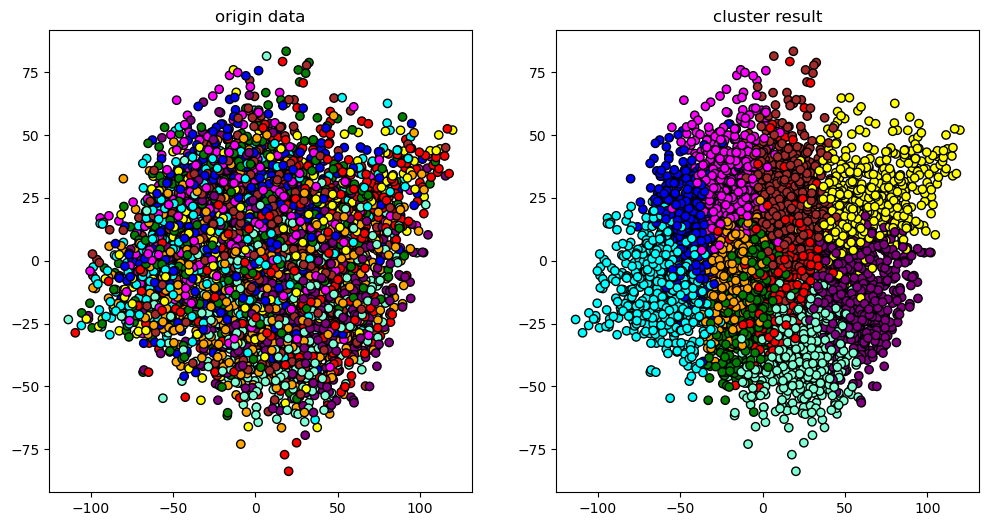

train time: 0.011500 s
execution time: 11.432529 s

acc: 0.200125
error: 0.799875

macro precision_score: 0.20591608304702907
micro precision_score: 0.200125
weighted precision_score: 0.20635891263106076
every precision_score: [0.21800281 0.16049383 0.19933555 0.10780287 0.18357488 0.1899696
 0.20599739 0.17838405 0.31061807 0.30498177]

macro recall_score: 0.19967040948921633
micro recall_score: 0.200125
weighted recall_score: 0.200125
every recall_score: [0.20861373 0.20660147 0.15286624 0.13548387 0.19412516 0.1541307
 0.19221411 0.20432692 0.2396088  0.30873309]

confusion_matrix: [[155  50 173  44  16  11  40  50 108  96]
 [ 77 169  29 107  64  65  86  37  92  92]
 [ 48 135 120 107  47  56  97 125  19  31]
 [ 37  81  64 105 108  82  98 134  32  34]
 [ 34 100  29 106 152  95  87 128  17  35]
 [ 31 116  45  87 137 125  85 156   9  20]
 [ 27 179  52  99  79 125 158  80  10  13]
 [ 51  69  41 127 149  51  52 170  30  92]
 [162  88  28  52  54  16  25  38 196 159]
 [ 89  66  21 140  22

In [25]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

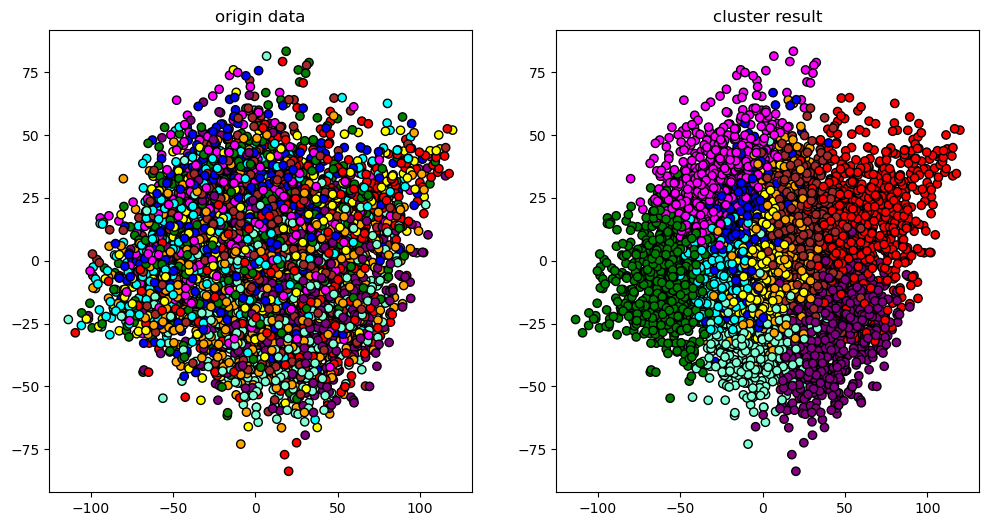

train time: 0.017988 s
execution time: 18.760951 s

acc: 0.207875
error: 0.792125

macro precision_score: 0.20723527056869476
micro precision_score: 0.207875
weighted precision_score: 0.20726021632818273
every precision_score: [0.26459144 0.09968847 0.16132723 0.12947368 0.20419426 0.17852162
 0.25204201 0.17124183 0.336      0.27527216]

macro recall_score: 0.2082581323711273
micro recall_score: 0.207875
weighted recall_score: 0.207875
every recall_score: [0.27456258 0.07823961 0.17961783 0.15870968 0.23627075 0.15782984
 0.26277372 0.15745192 0.3594132  0.21771218]

confusion_matrix: [[204 147  28  43  23  26  25  52 152  43]
 [ 85  64  68 112  64  78 128  43  84  92]
 [114  41 141 107  60  56 116  94  25  31]
 [ 73  40  99 123 115  85  63 100  24  53]
 [ 34  30 122 105 185  77  95  81  22  32]
 [ 39  36 106 127 157 128  68 112  13  25]
 [ 49  12 104 182  88  61 216  82  11  17]
 [ 38  40 120  69 143  72  67 131  48 104]
 [ 71 146  20  33  43  99  22  21 294  69]
 [ 64  86  66  49  2

In [26]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

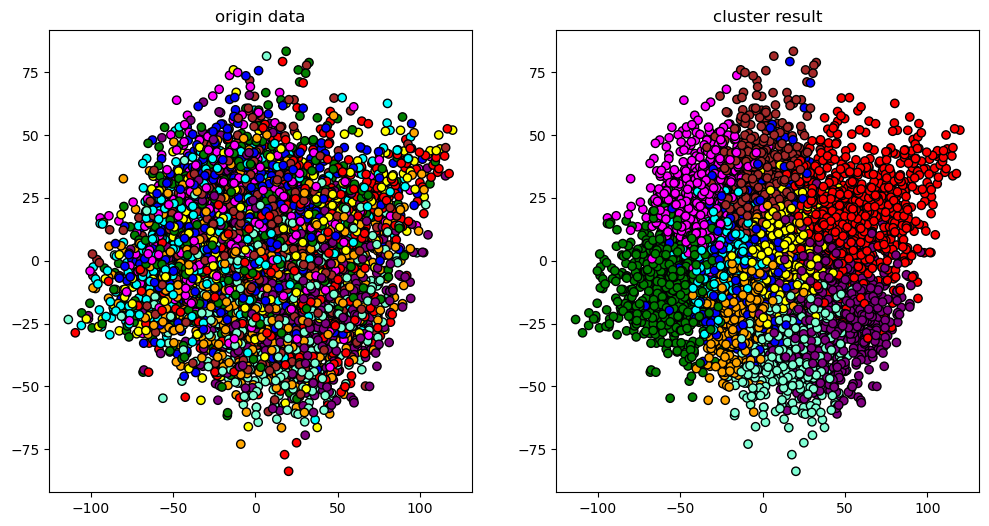

train time: 0.015794 s
execution time: 42.335768 s

acc: 0.215125
error: 0.784875

macro precision_score: 0.21675175166468774
micro precision_score: 0.215125
weighted precision_score: 0.21767056197141754
every precision_score: [0.21153846 0.18110236 0.13940092 0.11985899 0.20953757 0.14050633
 0.25259067 0.20680272 0.37947494 0.32670455]

macro recall_score: 0.21493769659440773
micro recall_score: 0.215125
weighted recall_score: 0.215125
every recall_score: [0.28129206 0.16870416 0.15414013 0.1316129  0.18518519 0.13686806
 0.23722628 0.18269231 0.38875306 0.28290283]

confusion_matrix: [[209  34  50  37  11 132  18  18 173  61]
 [ 69 138  62 113  38 102  71  51  91  83]
 [156  65 121  96  54  54 124  57  25  33]
 [114  83  83 102  95  69  67  98  24  40]
 [ 63  61  87  83 145  34 119 135  27  29]
 [ 93  74  92 107 132 111  53 107  16  26]
 [ 75  70  91 182  78  48 195  62   7  14]
 [ 79  83 147  57  79  40  73 152  25  97]
 [ 59  56  36  29  36 142  13  38 318  91]
 [ 71  98  99  45  

In [27]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

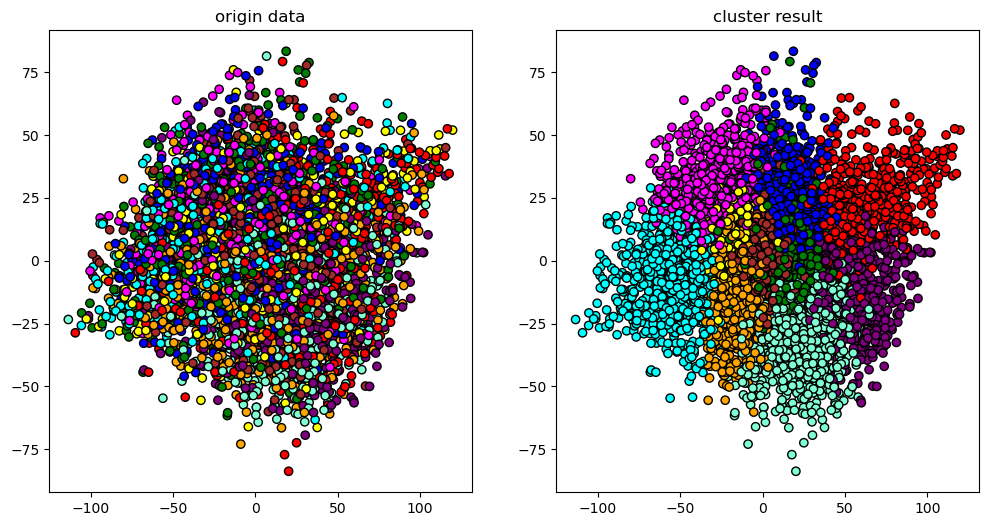

train time: 1.195921 s
execution time: 23.386702 s

acc: 0.208875
error: 0.791125

macro precision_score: 0.20603296276418584
micro precision_score: 0.208875
weighted precision_score: 0.20606846362796105
every precision_score: [0.29152542 0.18968531 0.15009747 0.07155026 0.20428894 0.18083462
 0.21675302 0.14916468 0.31702899 0.28940092]

macro recall_score: 0.20802398471874822
micro recall_score: 0.208875
weighted recall_score: 0.208875
every recall_score: [0.23149394 0.26528117 0.09808917 0.05419355 0.2311622  0.14426634
 0.3053528  0.15024038 0.21393643 0.38622386]

confusion_matrix: [[172  56   9 129  13  37  53  40  97 137]
 [ 29 217  20  52  67  19 139  60  83 132]
 [116 102  77  47  60  80 128 115  21  39]
 [ 64 113  42  42 118  91 142  96  28  39]
 [ 28  80  82  34 181  92 122 109  17  38]
 [ 45 130  54  34 157 117 151  91   9  23]
 [ 51 108 133  30  84  53 251  88   8  16]
 [ 41  90  69  52 130 115  79 125  21 110]
 [ 27 123  13 106  43  23  37  34 175 237]
 [ 17 125  14  61  

In [28]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

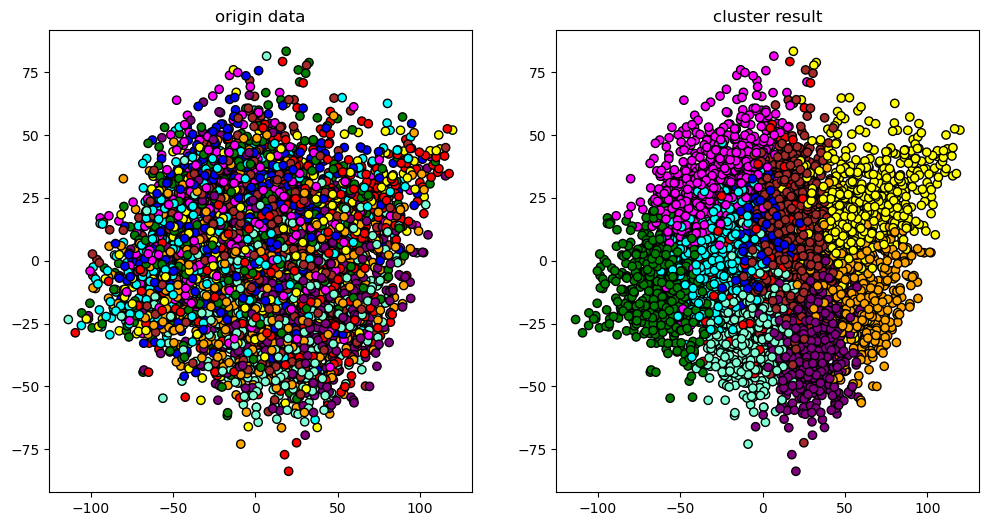

train time: 1.046237 s
execution time: 18.459150 s

acc: 0.203875
error: 0.796125

macro precision_score: 0.20904512310279308
micro precision_score: 0.203875
weighted precision_score: 0.2083479197531082
every precision_score: [0.3525641  0.1278826  0.18313953 0.12320917 0.18577495 0.17957746
 0.22661871 0.17737003 0.32384824 0.21046644]

macro recall_score: 0.20251540377011085
micro recall_score: 0.203875
weighted recall_score: 0.203875
every recall_score: [0.14804845 0.07457213 0.16050955 0.11096774 0.22349936 0.12577065
 0.38321168 0.27884615 0.29217604 0.22755228]

confusion_matrix: [[110  61 201  34  21  14  37  94 121  50]
 [ 29  61  48  86  71  76 151  88  74 134]
 [ 23  22 126  86  63  61 173 147  20  64]
 [ 13  33  70  86 138  50 129 151  18  87]
 [  6  14  33  79 175  70 181 149  18  58]
 [  6  11  49  74 176 102 161 165  14  53]
 [  4  27  49 143  77  61 315  92  11  43]
 [  5  23  49  52 137  71 119 232  39 105]
 [ 96 115  41  24  55  30  49  69 239 100]
 [ 20 110  22  34  2

In [29]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

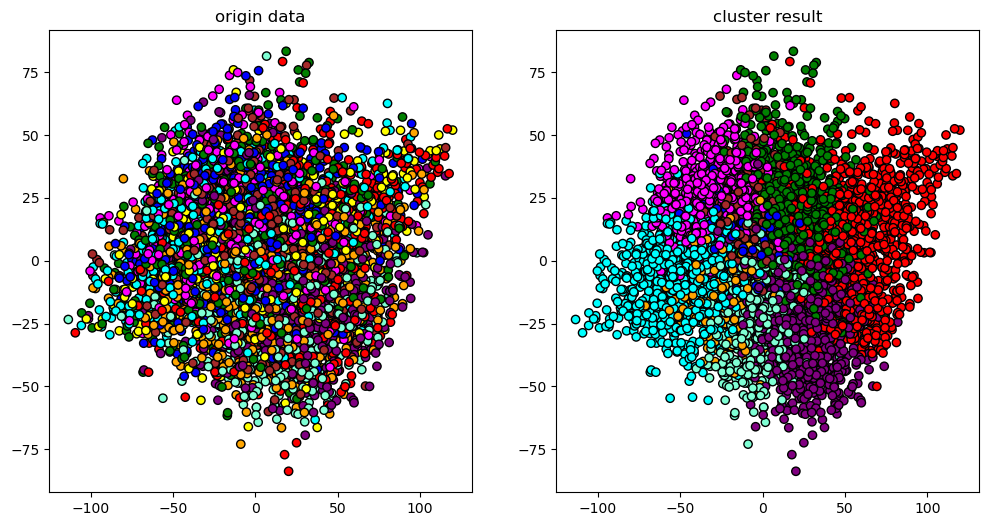

train time: 1.193075 s
execution time: 45.599636 s

acc: 0.21125
error: 0.7887500000000001

macro precision_score: 0.18769009771878284
micro precision_score: 0.21125
weighted precision_score: 0.18795794537192925
every precision_score: [0.27021696 0.23462415 0.         0.13770795 0.20314389 0.17537313
 0.2253109  0.20250522 0.2575406  0.17047817]

macro recall_score: 0.21175107299456078
micro recall_score: 0.21125
weighted recall_score: 0.21125
every recall_score: [0.36877524 0.12591687 0.         0.19225806 0.21455939 0.11590629
 0.37469586 0.11658654 0.40709046 0.20172202]

confusion_matrix: [[274  39   0  61  11  28  54   7 227  42]
 [ 88 103   0  62  36  57 168  41 158 105]
 [119  32   0 128  63  56 167  50  59 111]
 [ 76  30   0 149 116  62 154  58  43  87]
 [ 46  16   0 123 168  62 158  75  47  88]
 [ 37  51   0 166 173  94 136  53  27  74]
 [ 47  28   0  97 102  41 308  64  15 120]
 [ 49  35   0 183  95  46 101  97 101 125]
 [185  72   1  46  36  44  44  11 333  46]
 [ 93  33   0

In [30]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)